#Introdução

Este notebook apresenta o processo de criação de uma rede neural para predição de fraudes em contas de agua para a Aegea, os dados presentes nesse notebook já foram previamente tratados e analisados no nosso notebook de analise e preparação

A Aegea, criada em 2010, é uma das principais referências no setor privado de saneamento básico no Brasil. Com atuação em mais de 500 cidades, em 15 estados, a empresa atende mais de 31 milhões de pessoas, levando saúde e qualidade de vida através da gestão de serviços essenciais como o abastecimento de água e tratamento de esgoto.

#Importação de Configurações

##Instalação das bibliotecas

In [1]:
!pip install keras
!pip install keras-tuner
!pip install ann_visualizer
!pip install graphviz
!pip install h5py
!pip install scikit-learn haversine
!pip install keras scikit-learn bayesian-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=afe14c80ec628b2176c4ddb83e646d832a868b2caf8d1682148e110652f37ec1
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


##Importação das bibliotecas

In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras_tuner import RandomSearch
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import datetime
from keras.utils import plot_model
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
from bayes_opt import BayesianOptimization
from keras.models import Sequential
from google.colab import drive
from keras.layers import Dense

#Carregamento e visualização dos dados

##Carregando os dados

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/Shareddrives/M11_SI/final_base2.parquet'
df = pd.read_parquet(file_path)

df.head()

Mounted at /content/drive


,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
0,17000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.406525,0.0,0.274805,-0.235090,-0.456189,-0.201091,0.689645,1.712319,0.254239,0
1,17075331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
2,17075333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
3,17075335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
4,17075336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1


##Breve visualização dos dados tratados

In [4]:
#colunas e tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379575 entries, 0 to 379574
Columns: 828 entries, MATRICULA_NaT to FRAUDE
dtypes: float64(801), int64(3), object(24)
memory usage: 2.3+ GB


In [5]:
#Quantidade de linhas e colunas
df.shape

(379575, 828)

In [6]:
df.describe() #estatísticas descritivas das colunas numéricas

,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
count,3.795750e+05,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,...,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379575.000000
mean,1.764489e+07,0.075735,0.075716,0.075569,0.075484,0.075495,0.075432,0.075353,0.075139,0.075095,...,0.339136,0.067815,0.418885,0.504726,0.239797,0.242035,0.779648,0.201204,0.345470,0.324047
std,2.895757e+05,0.264574,0.264544,0.264307,0.264172,0.264189,0.264087,0.263960,0.263616,0.263544,...,1.030344,0.268031,1.240494,1.313272,0.908663,0.836946,1.498094,0.869290,1.014762,0.468018
min,1.700000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.509131,0.000000,-0.422257,-0.289046,-0.643034,-0.662401,-0.020646,-0.885798,-0.435542,0.000000
25%,1.735924e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.343662,0.000000,-0.320372,-0.284548,-0.400940,-0.379809,-0.020646,-0.418429,-0.328626,0.000000
50%,1.778456e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.788381e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.656338,0.000000,0.679628,0.715452,0.599060,0.620191,0.979354,0.581571,0.671374,1.000000
max,1.798557e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.926554,7.124459,13.588117,25.688940,14.845436,6.760050,18.437627,9.377607,14.029310,1.000000


In [7]:
df = df.select_dtypes(include=['int64', 'float64'])

### Tratamento basico

consideramos que o dataset estava 90% preparado para esta etapa, então vamos realizar alguns pequenos ajustes commo a remoção das colunas de fraude que que estão duplicadas e também ajustes de alguns valores infinitos ou nan

In [8]:
# Preencher valores NaN com 0
df.fillna(0, inplace=True)

# Substituir valores infinitos por 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Verifique se ainda há NaN ou infinitos após o tratamento
print("NaNs após o tratamento:", df.isnull().sum().sum())  # Deve ser 0
print("Infinitos após o tratamento:", np.isinf(df).sum().sum())  # Deve ser 0


NaNs após o tratamento: 0
Infinitos após o tratamento: 0


In [9]:
# Nome da coluna que você quer manter
coluna_a_manter = 'FRAUDE'

# Filtrando o DataFrame para remover todas as outras colunas que contêm 'FRAUDE', exceto a que você quer manter
colunas_fraude = df.filter(regex='FRAUDE').columns
colunas_a_remover = [col for col in colunas_fraude if col != coluna_a_manter]

# Removendo as colunas indesejadas
df = df.drop(columns=colunas_a_remover)

#Divisão de treino e teste

###Definindo X e Y

In [10]:
X = df.drop(columns=['FRAUDE','MATRICULA','MATRICULA_NaT'])  # Exclua a coluna do rótulo para ter as features
y = df['FRAUDE']  # Essa coluna é o que queremos prever

###Dividindo

In [11]:
# Dividindo os dados em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###Undersample

In [12]:
# Inicializando o RandomUnderSampler
undersample = RandomUnderSampler(random_state=32)

# Aplicando o undersampling
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

# Verificando o balanceamento das classes após o undersampling
print('Distribuição das classes antes do undersampling:', Counter(y_train))
print('Distribuição das classes após o undersampling:', Counter(y_train_resampled))


Distribuição das classes antes do undersampling: Counter({0: 179616, 1: 86086})
Distribuição das classes após o undersampling: Counter({0: 86086, 1: 86086})


#Definição da Estrutura da Rede Neural

### Definindo o modelo sequencial

In [13]:
pip install tensorflow

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()

###Camada de entrada

In [15]:
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###Aplicando early stopping


In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # Métrica a ser monitorada
    patience=5,              # Número de épocas com perda de validação sem melhoria
    restore_best_weights=True # Restaurar os pesos do modelo para o melhor estado
)

###Camadas ocultas

In [17]:
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))


###Camada de saida

In [18]:
model.add(Dense(1, activation='sigmoid'))

###Modelo compilado

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##Modelo inicial

In [20]:
# Treinamento do modelo
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5619 - loss: 0.7977 - val_accuracy: 0.6431 - val_loss: 0.6544
Epoch 2/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6009 - loss: 0.6524 - val_accuracy: 0.6425 - val_loss: 0.6626
Epoch 3/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6164 - loss: 0.6413 - val_accuracy: 0.6417 - val_loss: 0.6499
Epoch 4/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6266 - loss: 0.6327 - val_accuracy: 0.6776 - val_loss: 0.6320
Epoch 5/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6379 - loss: 0.6234 - val_accuracy: 0.6570 - val_loss: 0.6355
Epoch 6/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6459 - loss: 0.6145 - val_accuracy: 0.6420 - val_loss: 0.6356
Epoch 7/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6508 - loss: 0.6100 - val_accuracy: 0.6384 - val_loss: 0.6353
Epoch 8/10
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6617 - loss: 0

# Otimização do modelo

### Realizando a busca de hiperparâmetros


### Inicializando o Keras Tuner

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras_tuner import HyperParameters

def build_model(hp):
    model = Sequential()
    # Adiciona a primeira camada oculta
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=(X_train_resampled.shape[1],)))

    # Adiciona uma camada de dropout
    model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Adiciona a segunda camada oculta
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'))

    # Adiciona a camada de saída
    model.add(Dense(1, activation='sigmoid'))  # Para classificação binária. Para múltiplas classes, use softmax.

    # Compila o modelo
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',  # Para classificação binária
                  metrics=['accuracy'])

    return model

In [22]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
tuner.search(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Trial 10 Complete [00h 02m 01s]
val_accuracy: 0.6758318543434143

Best val_accuracy So Far: 0.6979354023933411
Total elapsed time: 00h 20m 09s


### Resumo dos resultados

In [24]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
units1: 448
dropout1: 0.5
units2: 288
learning_rate: 0.0023475850027156703
Score: 0.6979354023933411

Trial 06 summary
Hyperparameters:
units1: 512
dropout1: 0.1
units2: 160
learning_rate: 0.001726071629577545
Score: 0.6869582533836365

Trial 05 summary
Hyperparameters:
units1: 128
dropout1: 0.30000000000000004
units2: 96
learning_rate: 0.008314501799332779
Score: 0.6759021282196045

Trial 00 summary
Hyperparameters:
units1: 256
dropout1: 0.4
units2: 320
learning_rate: 0.007145215432053777
Score: 0.6758318543434143

Trial 09 summary
Hyperparameters:
units1: 192
dropout1: 0.5
units2: 352
learning_rate: 0.004714515179614474
Score: 0.6758318543434143

Trial 04 summary
Hyperparameters:
units1: 96
dropout1: 0.2
units2: 224
learning_rate: 0.0029371969717817744
Score: 0.674426794052124

Trial 07 summary
Hyperparameters:
units1: 64
dropout1: 0.3

#### Melhor modelo encontrado


In [25]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Avaliando o melhor modelo nos dados de teste

In [26]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

3559/3559 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6964 - loss: 0.6592
Test accuracy: 0.6979


#Avaliação e Relatório de Resultados

###Recuperando o melhor modelo

In [41]:
# Recuperar o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
# Avaliar o modelo ou usá-lo para previsões
loss, accuracy = .evaluate(X_test, y_test)

3559/3559 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6964 - loss: 0.6592


### Precision, Recall e F1-Score

In [48]:
y_pred_proba = best_model.predict(X_test)  # Probabilidades preditas
y_pred = (y_pred_proba > 0.5).astype("int32")

3559/3559 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


<ipython-input-51-9cd3b521eab4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


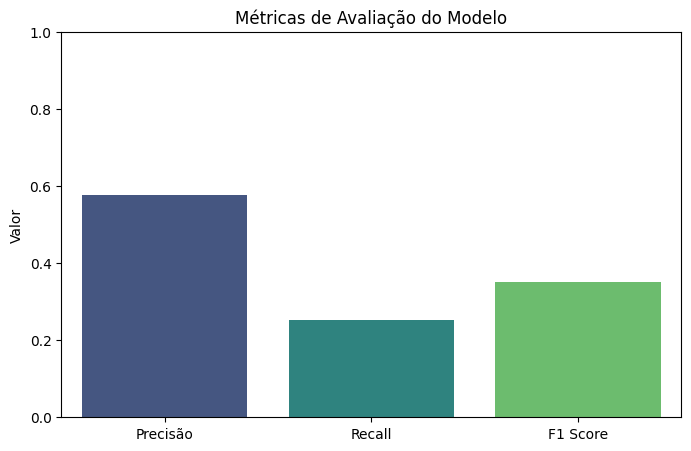

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = [precision, recall, f1]
labels = ['Precisão', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title('Métricas de Avaliação do Modelo')
plt.ylabel('Valor')
plt.ylim(0, 1)  # Definindo limite de 0 a 1
plt.show()


In [55]:
print(metrics)

[0.577911223921253, 0.2528850842498781, 0.3518193981193586]


Curva ROC

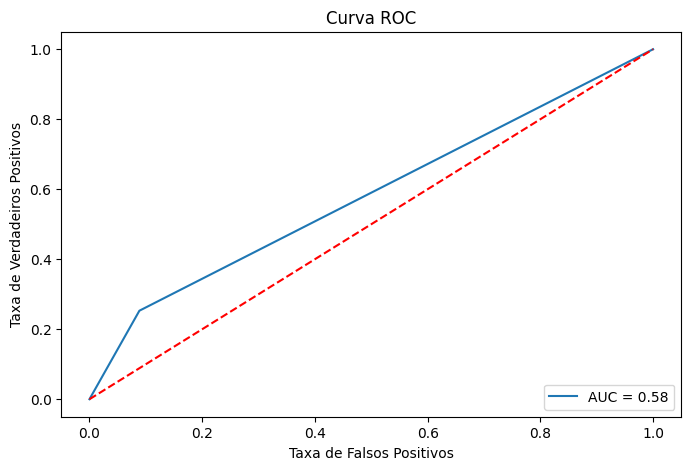

In [52]:
from sklearn.metrics import roc_curve, auc

# Supondo que y_pred_prob sejam as probabilidades das classes positivas
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')  # Linha de aleatoriedade
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


In [57]:
print(roc_auc)

0.5821462285034004


###Matriz de confusão

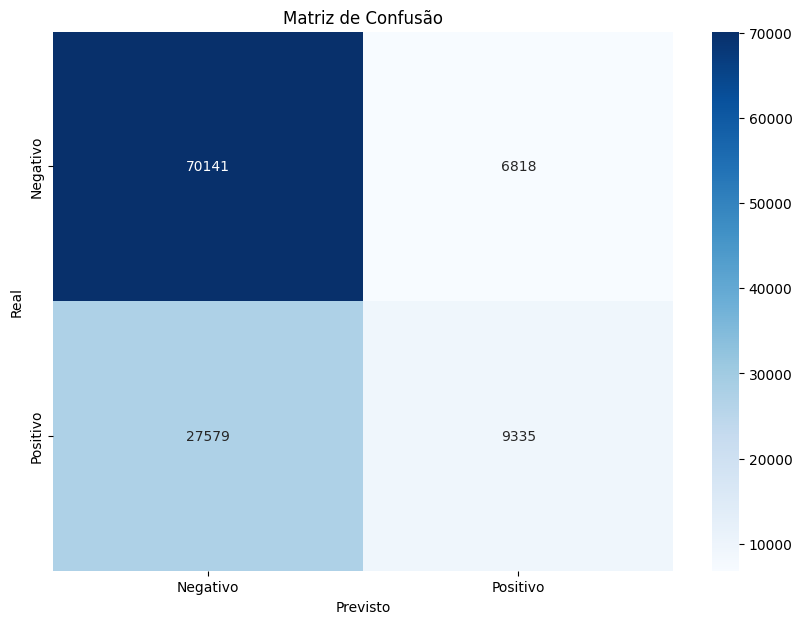

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Supondo que y_test e y_pred sejam definidos
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()


In [56]:
print(cm)

[[70141  6818]
 [27579  9335]]
